In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf


In [2]:
tf.test.gpu_device_name()

2022-12-06 06:23:25.731015: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 06:23:25.889803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 06:23:25.902568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 06:23:25.904507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, 

'/device:GPU:0'

In [3]:
train_dataset = tf.data.experimental.load("./acceptance-train.tfrecords")
validation_dataset = tf.data.experimental.load("./acceptance-validation.tfrecords").batch(1000)

X, y = next(iter(train_dataset.batch(100000)))

2022-12-06 06:23:26.796036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 06:23:26.797257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 06:23:26.798366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 06:23:26.799862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 06:23:26.801005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [4]:
model_type = 'pure_sequential'
#model_type = 'with_residual_layers'

In [5]:
if model_type == 'pure_sequential':
    layers = []
    layers += [tf.keras.layers.Dense(
        128, 
        activation='tanh', 
        kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.L2(1e-3)) for _ in range(4)]

    model = tf.keras.models.Sequential()
    for layer in layers:
        model.add(layer)
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.build(input_shape = [None, X.shape[1]])
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 51,073
Trainable params: 51,073
Non-trainable params: 0
_________________________________________________________________


In [6]:
if model_type == 'with_residual_layers':
    input = tf.keras.layers.Input(batch_input_shape=[None]+X.shape[1:])
    x = tf.keras.layers.Dense(
        128, activation='tanh',
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.L2(1e-3)
    )(input)

    for i in range(10):
        r = tf.keras.layers.Dense(128, activation='tanh', kernel_initializer='zeros')(x)
        x = tf.keras.layers.Add()([x, r])
    x = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

    model = tf.keras.Model(inputs=[input], outputs=[x])
    model.summary()

In [7]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop

In [8]:
model.compile(loss=BinaryCrossentropy(label_smoothing=0.01), optimizer=RMSprop(10e-3))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
data = train_dataset.batch(100_000).prefetch(tf.data.AUTOTUNE)
history = model.fit(data, epochs=50, validation_data=next(iter(validation_dataset)), callbacks=[early_stopping])

Epoch 1/50
7/7 [==============================] - 7s 860ms/step - loss: 2.3833 - val_loss: 1.6598
Epoch 2/50
7/7 [==============================] - 6s 839ms/step - loss: 1.4974 - val_loss: 1.3220
Epoch 3/50
7/7 [==============================] - 5s 694ms/step - loss: 1.3441 - val_loss: 1.4016
Epoch 4/50
7/7 [==============================] - 5s 742ms/step - loss: 1.2545 - val_loss: 1.1067
Epoch 5/50
7/7 [==============================] - 6s 812ms/step - loss: 1.0736 - val_loss: 1.0149
Epoch 6/50
7/7 [==============================] - 5s 755ms/step - loss: 1.0224 - val_loss: 1.0679
Epoch 7/50
7/7 [==============================] - 5s 705ms/step - loss: 0.9420 - val_loss: 1.1741
Epoch 8/50
7/7 [==============================] - 6s 803ms/step - loss: 0.9199 - val_loss: 0.7788
Epoch 9/50
7/7 [==============================] - 6s 792ms/step - loss: 0.8032 - val_loss: 0.8425
Epoch 10/50
7/7 [==============================] - 5s 730ms/step - loss: 0.7742 - val_loss: 0.6755
Epoch 11/50
7/7 [==

In [9]:
model.compile(loss=BinaryCrossentropy(label_smoothing=0.00), optimizer=RMSprop(1e-3))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
data = train_dataset.batch(100_000).prefetch(tf.data.AUTOTUNE)
history_ft = model.fit(data, epochs=50, validation_data=next(iter(validation_dataset)), callbacks=[early_stopping])

Epoch 1/50
7/7 [==============================] - 10s 778ms/step - loss: 0.5631 - val_loss: 0.5328
Epoch 2/50
7/7 [==============================] - 6s 808ms/step - loss: 0.5224 - val_loss: 0.5254
Epoch 3/50
7/7 [==============================] - 5s 781ms/step - loss: 0.5090 - val_loss: 0.5095
Epoch 4/50
7/7 [==============================] - 6s 781ms/step - loss: 0.4993 - val_loss: 0.5102
Epoch 5/50
7/7 [==============================] - 5s 751ms/step - loss: 0.4937 - val_loss: 0.4975
Epoch 6/50
7/7 [==============================] - 5s 703ms/step - loss: 0.4860 - val_loss: 0.5019
Epoch 7/50
7/7 [==============================] - 6s 775ms/step - loss: 0.4830 - val_loss: 0.4892
Epoch 8/50
7/7 [==============================] - 5s 737ms/step - loss: 0.4763 - val_loss: 0.5000
Epoch 9/50
7/7 [==============================] - 7s 971ms/step - loss: 0.4753 - val_loss: 0.4839
Epoch 10/50
7/7 [==============================] - 7s 924ms/step - loss: 0.4688 - val_loss: 0.4930
Epoch 11/50
7/7 [=

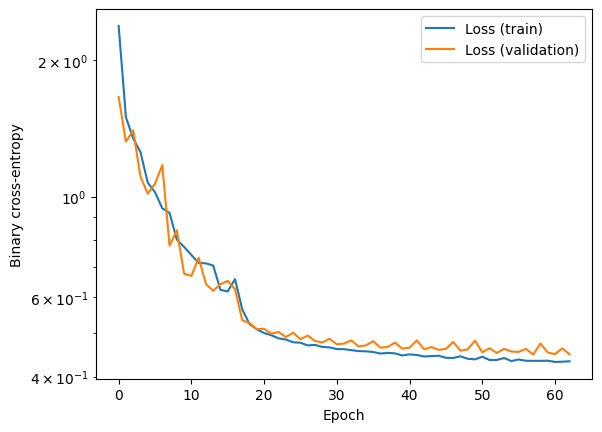

In [10]:
plt.plot(history.history['loss'] + history_ft.history['loss'], label="Loss (train)")
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label="Loss (validation)")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.yscale('log')
plt.legend()
plt.show()

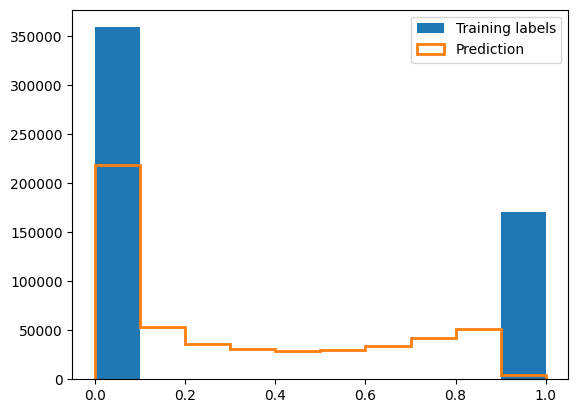

In [11]:
Xv, yv = next(iter(validation_dataset.unbatch().batch(1_000_000).as_numpy_iterator()))
yv_hat = model.predict(Xv, batch_size=len(Xv))
bins = np.linspace(0, 1, 11)
plt.hist(yv, bins=bins, label="Training labels")
plt.hist(yv_hat, bins=bins, histtype='step', linewidth=2, label="Prediction")
plt.legend()
plt.show()

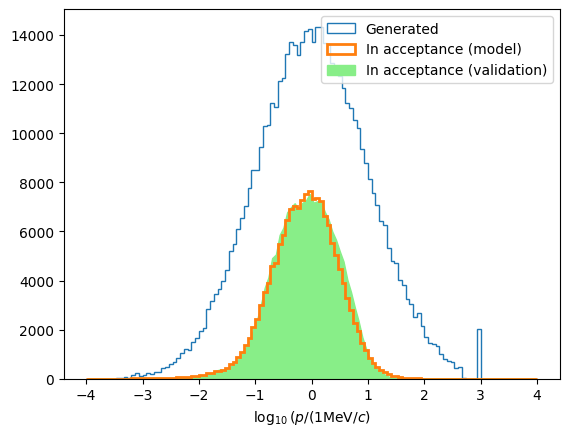

In [12]:
log_p = Xv[:,3]
bins = np.linspace(-4, 4, 121)
denominator, _ = np.histogram(log_p, bins=bins)
true_numerator, _ = np.histogram(log_p, bins=bins, weights=yv.flatten())
predicted_numerator, _ = np.histogram(log_p, bins=bins, weights=yv_hat.flatten())

plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=denominator, label="Generated", histtype='step')
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=predicted_numerator, label="In acceptance (model)", histtype='step', linewidth=2)
#plt.plot((bins[1:] + bins[:-1])/2, predicted_numerator, label="In acceptance (model)")
plt.fill_between(
    (bins[1:] + bins[:-1])/2, np.zeros(len(true_numerator)), true_numerator,
    label="In acceptance (validation)",
    color='#88ee88'
)
plt.xlabel(r"$\log_{10} \left(p / (1 \mathrm{MeV}/c\right)$")
plt.legend()
plt.show()

In [13]:
!mkdir -p /workarea/cloud-storage/anderlinil/models
model.save("/workarea/cloud-storage/anderlinil/models/acceptance")

2022-12-06 06:29:34.022367: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /workarea/cloud-storage/anderlinil/models/acceptance/assets
